<a href="https://colab.research.google.com/github/MLUISG/Projects/blob/main/Mark_Guereque_Project_4_V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 4: Music Popularity Predictions

## Problem Definition


> Can we use tree-based regression learning techniques to predict song popularity on Spotify?



## Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn import datasets
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn import metrics  
import graphviz
from IPython.display import display
from sklearn import tree

##Mark's Radical Functions

In [ ]:
def show_me(df):
  """Displays info, describe, head, and tail
  
Money in the bank,
Show me the stats and details,
Info, head, tail, done."""
  print('Info')  
  print(df.info())
  print('\n')
  print('\n')
  print('Described')
  print(df.describe().T)
  print('\n')
  print('\n')
  print('Head')
  print(df.head().T)
  print('\n')
  print('\n')
  print('Tail')
  print(df.tail().T)

In [ ]:
def find_tuple_cols(df):
  """Identifies tuples in all columns in a dataframe

Tuple columns sought,
Amidst the data's great breadth,
Found and returned whole."""
  tuple_cols = [col for col in df.columns if df[col].apply(lambda x: isinstance(x, tuple)).any()]
  return tuple_cols

In [ ]:
def convert_tuples_to_lists(df):
  """Loops through columns, converting tuples

From tuples to lists,
DataFrame transformed with ease,
Data now unbound."""
  for col in df.columns:
      if type(df[col][0]) == tuple:
          df[col] = df[col].apply(list)
  return df

In [ ]:
def all_the_value_counts(df):
    """Prints the value counts for all columns in a pandas DataFrame
    
Counting values wide,
All columns, one by one revealed,
Insight to be found."""
    for column in df.columns:
        print(f"Value counts for {column}:")
        print(df[column].value_counts())
        print("\n")

In [ ]:
def remove_outliers(df):
  """Removes outliers from all columns in a dataframe with a threshold of 3* STD

Outliers expelled,
Data purged of impurities,
Clean and pristine now."""
  cleaned_data = df
  for col in df.columns:
      mean = df[col].mean()
      std = df[col].std()
      threshold = 3 * std
      lower_bound = mean - threshold
      upper_bound = mean + threshold
      cleaned_data[col] = df[col][(df[col] > lower_bound) & (df[col] < upper_bound)]
  return cleaned_data

In [ ]:
def count_the_cats(df):
    """Prints the value counts for categorical columns in a pandas DataFrame
    
Meow, count the cats,
Categorical values,
Pandas purrs content.
    """
    for column in df.select_dtypes(include=["category", "object"]).columns:
        print(f"Value counts for {column}:")
        print(df[column].value_counts())
        print("\n")

In [ ]:
def impute_means(df):
  """Imputes the mean value of a column to all null values in that column
  
Missing values found,
Impute means to numeric cols,
Clean data once more."""
  for col in df.columns:
        if df[col].isna().sum() == 0:
            continue
        if pd.api.types.is_numeric_dtype(df[col]):
            df[col].fillna(df[col].mean(), inplace=True)
  return df

In [ ]:
def count_nulls(data):
    """Checks for null values and displays only nulls
    
Null values abound,
Display them with a function,
Data cleaning done."""
    temp = data.isna().sum()
    filter = temp > 0
    print(data.shape)
    print(temp[filter])

In [ ]:
def per_nulls(data):
    """Checks for null values and displays their percentage.

Null values lurking,
Percentage uncovered,
Data now refined."""
    total = data.isna().sum().sort_values(ascending=False)
    percent = round((data.isna().sum()/data.isna().count()*100), 2).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    missing_data = missing_data[missing_data['Total'] > 0]
    print("Missing data percentage:\n", missing_data)

# The Data 



###Load Data

###Mounting Data

In [ ]:
from google.colab import drive
drive.mount('/drive')

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


In [ ]:
data_path = '/drive/My Drive/Project 4/Data/Project_4_Spotify.csv'

##Master Data

In [ ]:
master_data = pd.read_csv(data_path)

## Collection/Source
Data is made up of information collected from songs that have been on the Top 200 Weekly (Global) charts of Spotify in 2020 & 2021.

##IDA intitial data analaysis

In [ ]:
master_data

,Index,Highest Charting Position,Number of Times Charted,Week of Highest Charting,Song Name,Streams,Artist,Artist Followers,Song ID,Genre,...,Danceability,Energy,Loudness,Speechiness,Acousticness,Liveness,Tempo,Duration (ms),Valence,Chord
0,1,1,8,2021-07-23--2021-07-30,Beggin',"48,633,449",Måneskin,3377762,3Wrjm47oTz2sjIgck11l5e,"['indie rock italiano', 'italian pop']",...,0.714,0.8,-4.808,0.0504,0.127,0.359,134.002,211560,0.589,B
1,2,2,3,2021-07-23--2021-07-30,STAY (with Justin Bieber),"47,248,719",The Kid LAROI,2230022,5HCyWlXZPP0y6Gqq8TgA20,['australian hip hop'],...,0.591,0.764,-5.484,0.0483,0.0383,0.103,169.928,141806,0.478,C#/Db
2,3,1,11,2021-06-25--2021-07-02,good 4 u,"40,162,559",Olivia Rodrigo,6266514,4ZtFanR9U6ndgddUvNcjcG,['pop'],...,0.563,0.664,-5.044,0.154,0.335,0.0849,166.928,178147,0.688,A
3,4,3,5,2021-07-02--2021-07-09,Bad Habits,"37,799,456",Ed Sheeran,83293380,6PQ88X9TkUIAUIZJHW2upE,"['pop', 'uk pop']",...,0.808,0.897,-3.712,0.0348,0.0469,0.364,126.026,231041,0.591,B
4,5,5,1,2021-07-23--2021-07-30,INDUSTRY BABY (feat. Jack Harlow),"33,948,454",Lil Nas X,5473565,27NovPIUIRrOZoCHxABJwK,"['lgbtq+ hip hop', 'pop rap']",...,0.736,0.704,-7.409,0.0615,0.0203,0.0501,149.995,212000,0.894,D#/Eb
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1551,1552,195,1,2019-12-27--2020-01-03,New Rules,"4,630,675",Dua Lipa,27167675,2ekn2ttSfGqwhhate0LSR0,"['dance pop', 'pop', 'uk pop']",...,0.762,0.7,-6.021,0.0694,0.00261,0.153,116.073,209320,0.608,A
1552,1553,196,1,2019-12-27--2020-01-03,Cheirosa - Ao Vivo,"4,623,030",Jorge & Mateus,15019109,2PWjKmjyTZeDpmOUa3a5da,"['sertanejo', 'sertanejo universitario']",...,0.528,0.87,-3.123,0.0851,0.24,0.333,152.37,181930,0.714,B
1553,1554,197,1,2019-12-27--2020-01-03,Havana (feat. Young Thug),"4,620,876",Camila Cabello,22698747,1rfofaqEpACxVEHIZBJe6W,"['dance pop', 'electropop', 'pop', 'post-teen ...",...,0.765,0.523,-4.333,0.03,0.184,0.132,104.988,217307,0.394,D
1554,1555,198,1,2019-12-27--2020-01-03,Surtada - Remix Brega Funk,"4,607,385","Dadá Boladão, Tati Zaqui, OIK",208630,5F8ffc8KWKNawllr5WsW0r,"['brega funk', 'funk carioca']",...,0.832,0.55,-7.026,0.0587,0.249,0.182,154.064,152784,0.881,F


In [ ]:
print(master_data.dtypes)

Index                         int64
Highest Charting Position     int64
Number of Times Charted       int64
Week of Highest Charting     object
Song Name                    object
Streams                      object
Artist                       object
Artist Followers             object
Song ID                      object
Genre                        object
Release Date                 object
Weeks Charted                object
Popularity                   object
Danceability                 object
Energy                       object
Loudness                     object
Speechiness                  object
Acousticness                 object
Liveness                     object
Tempo                        object
Duration (ms)                object
Valence                      object
Chord                        object
dtype: object


We can see that almost all the data is categorical.

In [ ]:
master_data.shape

(1556, 23)

###Data Info

In [ ]:
#This function will present the df info, describe, head, and tail.
show_me(master_data)

Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1556 entries, 0 to 1555
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Index                      1556 non-null   int64 
 1   Highest Charting Position  1556 non-null   int64 
 2   Number of Times Charted    1556 non-null   int64 
 3   Week of Highest Charting   1556 non-null   object
 4   Song Name                  1556 non-null   object
 5   Streams                    1556 non-null   object
 6   Artist                     1556 non-null   object
 7   Artist Followers           1556 non-null   object
 8   Song ID                    1556 non-null   object
 9   Genre                      1556 non-null   object
 10  Release Date               1556 non-null   object
 11  Weeks Charted              1556 non-null   object
 12  Popularity                 1556 non-null   object
 13  Danceability               1556 non-null   object
 14  Ene

###Value Counts

In [ ]:
#This will gives me an overveiw all of the values in the df
all_the_value_counts(master_data)

Value counts for Index:
1       1
1023    1
1045    1
1044    1
1043    1
       ..
516     1
515     1
514     1
513     1
1556    1
Name: Index, Length: 1556, dtype: int64


Value counts for Highest Charting Position:
1      18
2      18
5      17
15     15
22     15
       ..
98      2
173     2
165     2
200     2
178     1
Name: Highest Charting Position, Length: 200, dtype: int64


Value counts for Number of Times Charted:
1     509
2     149
3     110
4      77
5      71
     ... 
74      1
47      1
77      1
56      1
84      1
Name: Number of Times Charted, Length: 75, dtype: int64


Value counts for Week of Highest Charting:
2019-12-27--2020-01-03    89
2020-12-18--2020-12-25    68
2020-01-03--2020-01-10    51
2021-07-23--2021-07-30    46
2020-01-17--2020-01-24    39
                          ..
2021-01-22--2021-01-29     8
2020-12-25--2021-01-01     7
2020-10-09--2020-10-16     7
2020-12-04--2020-12-11     5
2021-02-19--2021-02-26     4
Name: Week of Highest Charting, Lengt

We can see that the majority of the data is categorical.

###Null Count

In [ ]:
#This function will display only nulls if there are any
count_nulls(master_data)

(1556, 23)
Series([], dtype: int64)


##Data Overview

We can see this is a fair sized dataset with 23 features, 1556 observations, no null values, and lots of categorical data.

# Data Cleaning
I will be dropping the following features because I don't find them relevant to preparing my first tests.

In [ ]:
dropped_data = master_data.drop(['Artist', 'Song ID', 'Song Name', 'Highest Charting Position', 'Number of Times Charted', 'Week of Highest Charting', 'Genre', 'Release Date', 'Weeks Charted'], axis=1)

In [ ]:
print(dropped_data.dtypes)

Index                int64
Streams             object
Artist Followers    object
Popularity          object
Danceability        object
Energy              object
Loudness            object
Speechiness         object
Acousticness        object
Liveness            object
Tempo               object
Duration (ms)       object
Valence             object
Chord               object
dtype: object


All these object types will get in the way of further processing so I will now change them into ints and floats.

In [ ]:
#This will be the codeblock where I convert objects into ints
dropped_data['Streams'] = dropped_data['Streams'].str.replace(',', '')#This had to be done first because 'Streams' contains commas that will prevent it from converting it into an int
dropped_data['Streams'] = dropped_data['Streams'].astype(int)
#Creating converted_data as my new working variable by using loc to drop any columns with ' '
converted_data = dropped_data.loc[dropped_data['Artist Followers'].str.isnumeric()].copy()
converted_data['Artist Followers'] = converted_data['Artist Followers'].astype(int)
converted_data['Popularity'] = converted_data['Popularity'].astype(int)
converted_data['Duration (ms)'] = converted_data['Duration (ms)'].astype(int)

In [ ]:
#This is the codeblock where I convert objects into floats
converted_data['Danceability'] = converted_data['Danceability'].astype(float)
converted_data['Energy'] = converted_data['Energy'].astype(float)
converted_data['Loudness'] = converted_data['Loudness'].astype(float)
converted_data['Speechiness'] = converted_data['Speechiness'].astype(float)
converted_data['Acousticness'] = converted_data['Acousticness'].astype(float)
converted_data['Liveness'] = converted_data['Liveness'].astype(float)
converted_data['Tempo'] = converted_data['Tempo'].astype(float)
converted_data['Valence'] = converted_data['Valence'].astype(float)

In [ ]:
converted_data.dtypes

Index                 int64
Streams               int64
Artist Followers      int64
Popularity            int64
Danceability        float64
Energy              float64
Loudness            float64
Speechiness         float64
Acousticness        float64
Liveness            float64
Tempo               float64
Duration (ms)         int64
Valence             float64
Chord                object
dtype: object

'Chord' is the only object I'll have to one-hot encode going forward.

In [ ]:
encoded_data = pd.get_dummies(converted_data['Chord'])
numeric_data = converted_data.drop(['Chord'], axis=1)
processed_data = pd.concat([numeric_data, encoded_data], axis=1)

In [ ]:
processed_data.dtypes

Index                 int64
Streams               int64
Artist Followers      int64
Popularity            int64
Danceability        float64
Energy              float64
Loudness            float64
Speechiness         float64
Acousticness        float64
Liveness            float64
Tempo               float64
Duration (ms)         int64
Valence             float64
A                     uint8
A#/Bb                 uint8
B                     uint8
C                     uint8
C#/Db                 uint8
D                     uint8
D#/Eb                 uint8
E                     uint8
F                     uint8
F#/Gb                 uint8
G                     uint8
G#/Ab                 uint8
dtype: object

Now my data is ready for modeling and testing with Random Forest for further feature selection.

In [ ]:
X = processed_data.drop('Popularity', axis = 1)
y = processed_data['Popularity']

In [ ]:
#I'm going to use Random Forest for further feature selection.
numLoops = 100

mean_error = np.zeros(numLoops)

np.random.seed(42)
for idx in range(0,numLoops):
  X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)
  model = RandomForestRegressor(n_estimators = 10, random_state=0) 
  model.fit(X_train,y_train)
  y_pred = model.predict(X_test)
  mean_error[idx] = mean_squared_error(y_test, y_pred)

print(f'RMSE: {np.sqrt(mean_error).mean()}')
print(f'RMSE_std: {np.sqrt(mean_error).std()}')
np.sqrt(mean_error)[:50]

RMSE: 9.62720995190653
RMSE_std: 1.5313185927581467


array([ 8.29333378,  8.84817645,  6.65137891,  8.61658858, 10.39217561,
        8.19631301,  9.21801564, 12.89497908,  8.39636036,  9.70146788,
       10.37201862,  9.86885362,  9.66988285,  9.52125029,  9.91954365,
       12.45767202, 10.20127221,  8.59092243,  9.87528706, 12.10597622,
        8.21312983, 11.46381531,  8.48799266, 11.00086346,  8.80620001,
        9.6669423 ,  9.88427046,  9.07055587, 10.4694439 ,  9.67156109,
       13.01835896, 11.81699588,  8.14818462,  9.79457283, 11.84516888,
       10.55372601,  9.06361194, 10.50481782,  9.00008091,  9.50493825,
        9.02343049,  7.44965845,  9.22791424,  8.61996441, 11.00894899,
        8.86719528,  9.33176015,  8.6871385 ,  8.79061356,  7.0530881 ])

Text(0, 0.5, 'Mean decrease in impurity')

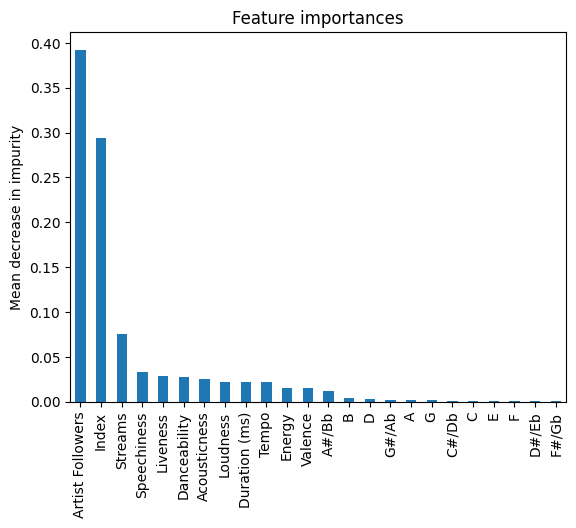

In [ ]:
importances = model.feature_importances_
importances
forest_importances = pd.Series(importances, index=X.columns)
forest_importances.sort_values(ascending=False, inplace=True)
plt.figure()
forest_importances.plot.bar()
plt.title("Feature importances")
plt.ylabel("Mean decrease in impurity")

In [ ]:
processed_data.dtypes

Index                 int64
Streams               int64
Artist Followers      int64
Popularity            int64
Danceability        float64
Energy              float64
Loudness            float64
Speechiness         float64
Acousticness        float64
Liveness            float64
Tempo               float64
Duration (ms)         int64
Valence             float64
A                     uint8
A#/Bb                 uint8
B                     uint8
C                     uint8
C#/Db                 uint8
D                     uint8
D#/Eb                 uint8
E                     uint8
F                     uint8
F#/Gb                 uint8
G                     uint8
G#/Ab                 uint8
dtype: object

'Artist Followers', 'Index', 'Streams', 'Speechiness', and 'Liveness' were determined to be the best top five features so I'm going forward with those for testing and modeling.



In [ ]:
top_five = processed_data[['Popularity','Artist Followers', 'Index', 'Streams', 'Speechiness', 'Liveness']]

#EDA

##Correation Data

<Axes: >

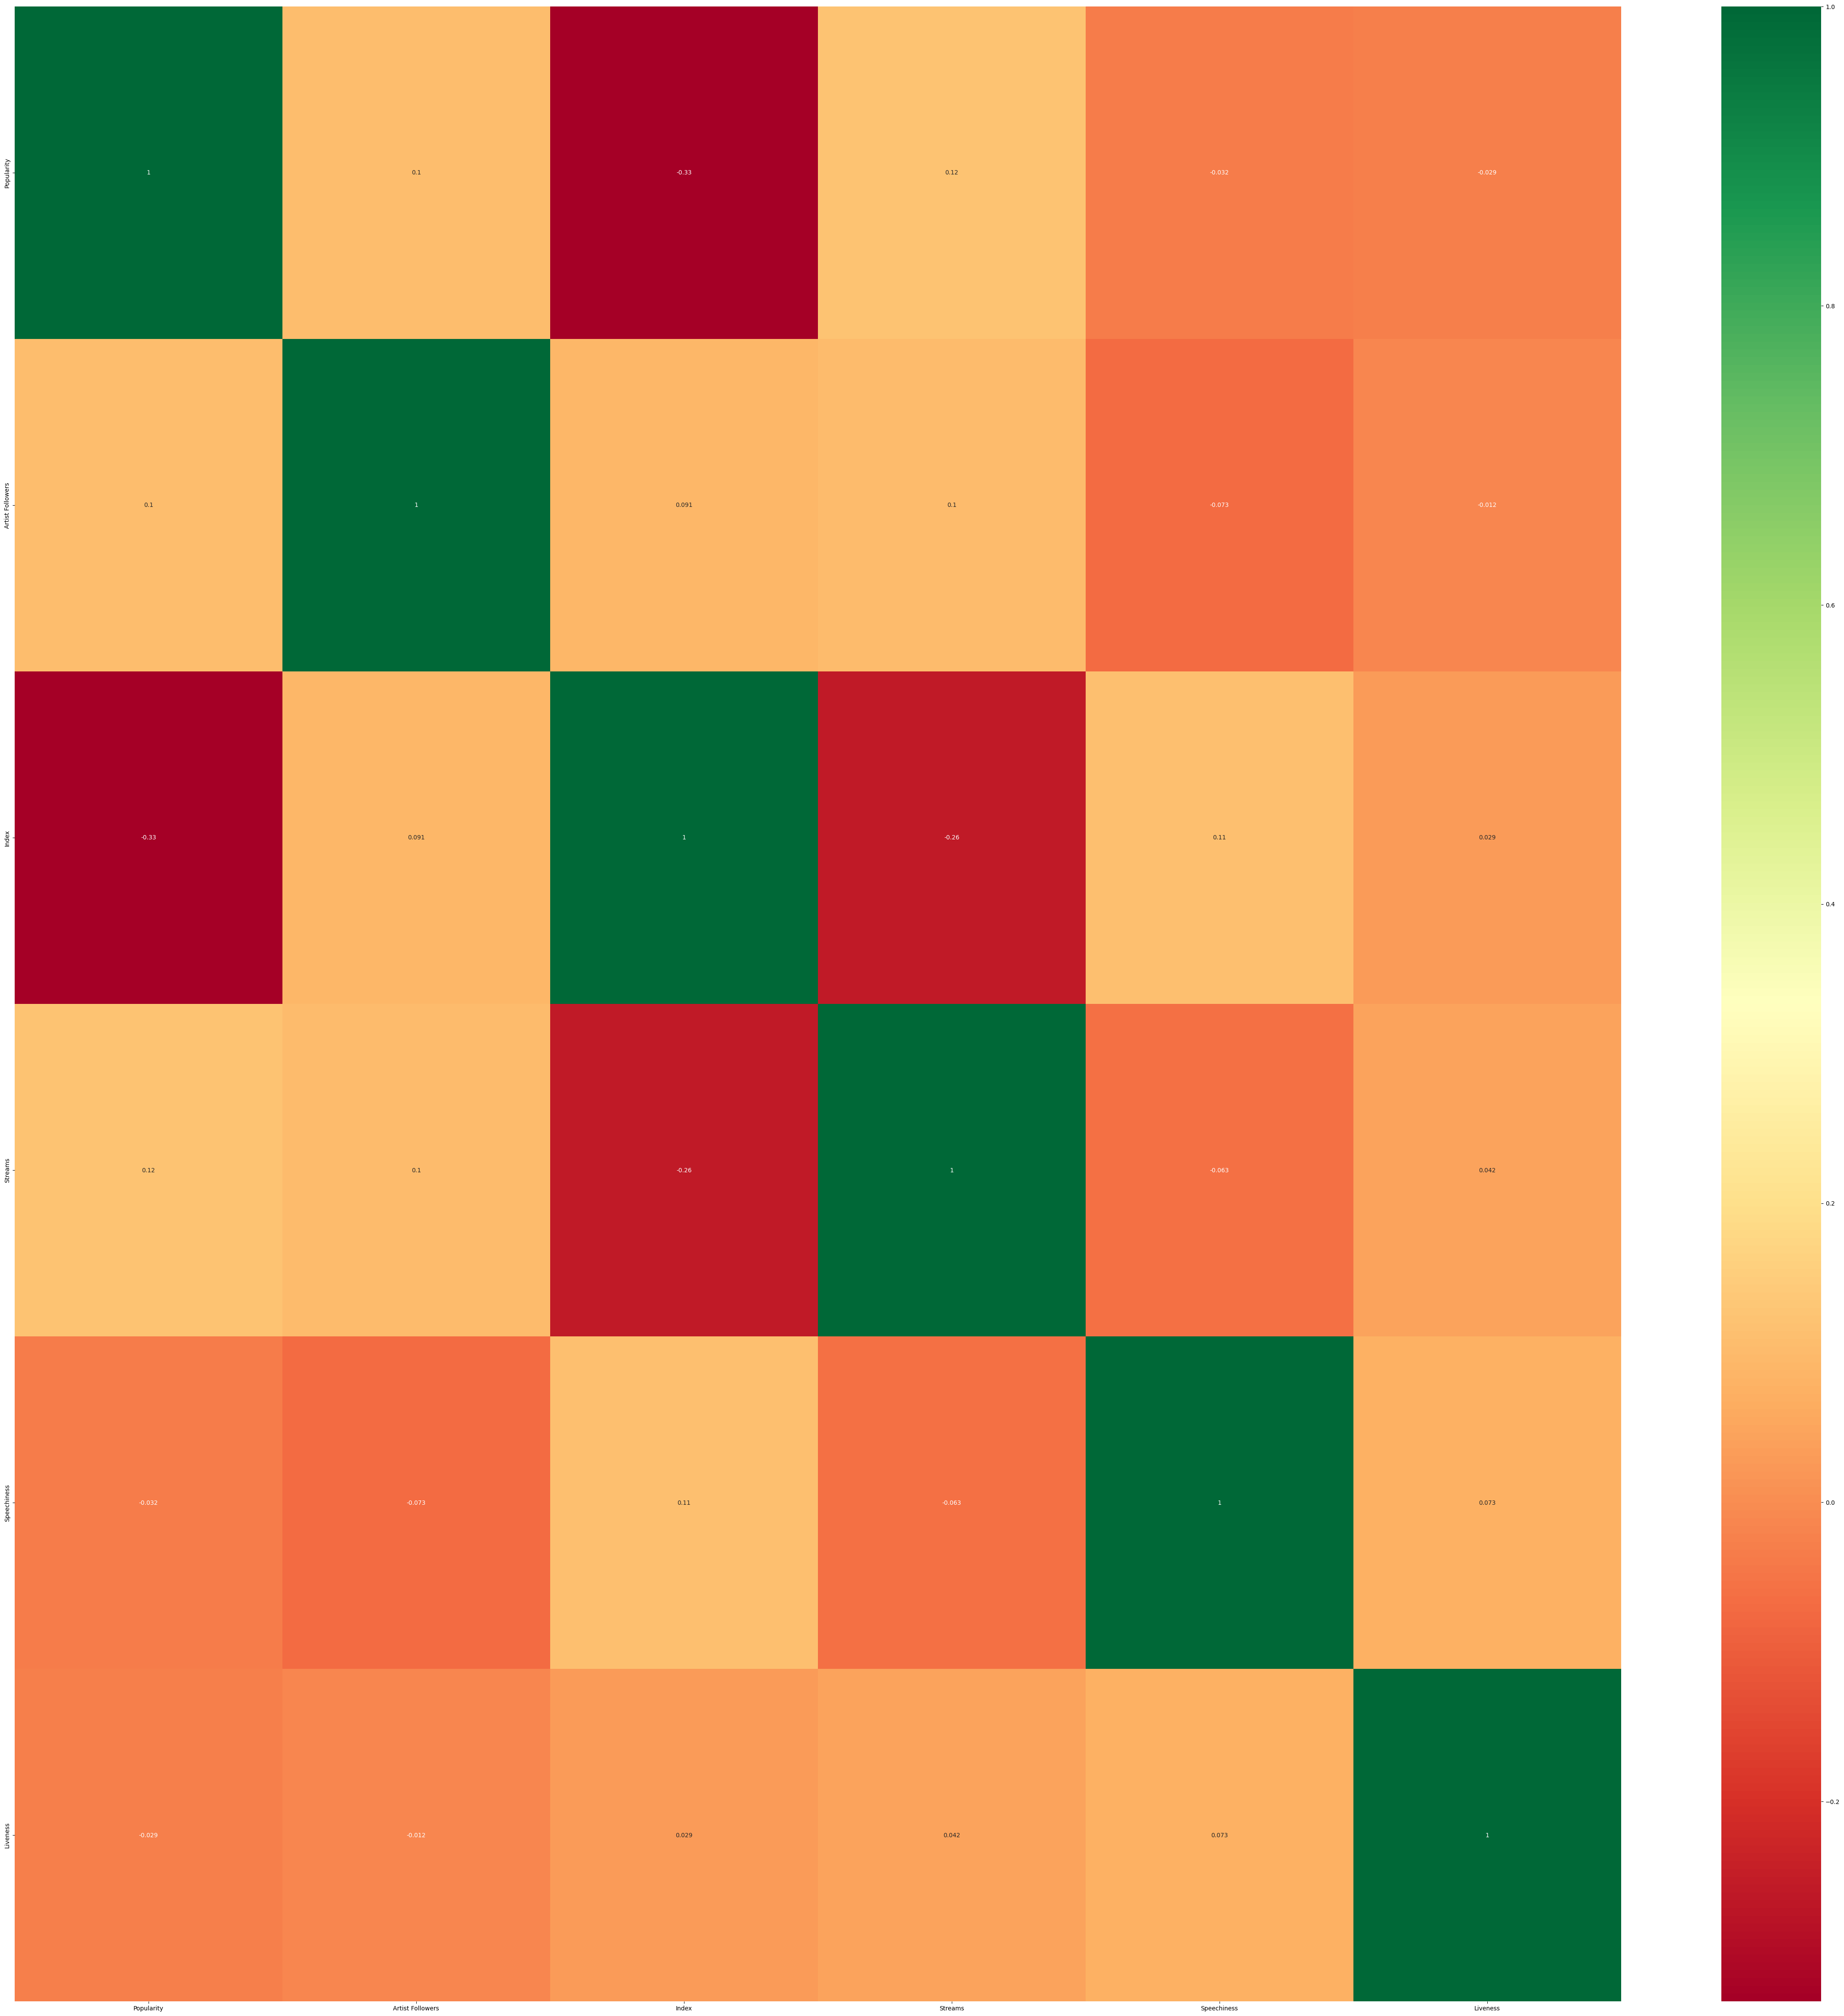

In [ ]:
data_corr = top_five.corr()
plt.figure(figsize=(60,60))
sns.heatmap(data_corr, annot=True, cmap='RdYlGn')

Text(0.5, 0, 'Top Five Features With Target')

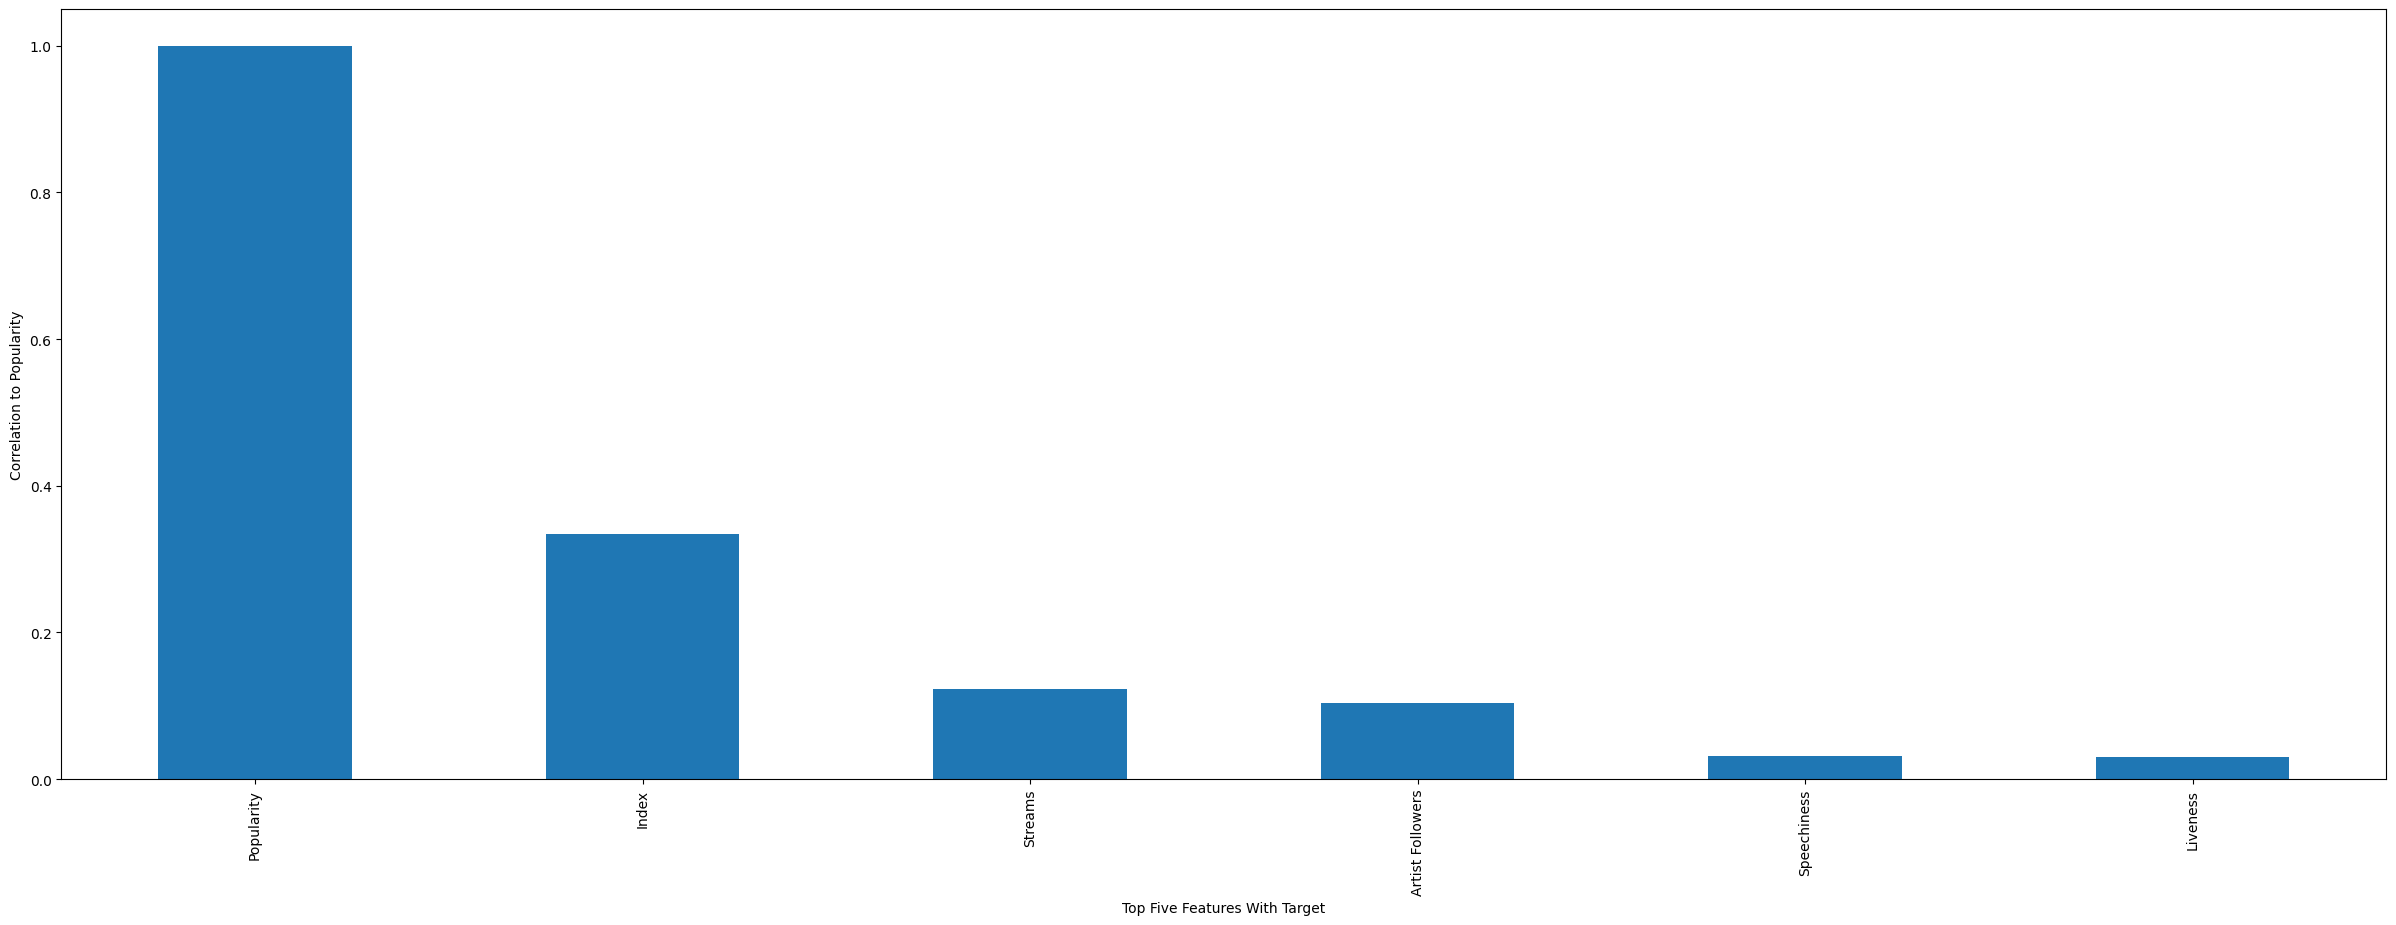

In [ ]:
ax = top_five.corr()['Popularity'].abs().sort_values(ascending = False).plot(kind = 'bar', figsize = (30,10))
ax.set_ylabel('Correlation to Popularity')
ax.set_xlabel('Top Five Features With Target')

This correlation matrix and pair plot will help us visualize and understand the data we are working with.

##Data Graphs



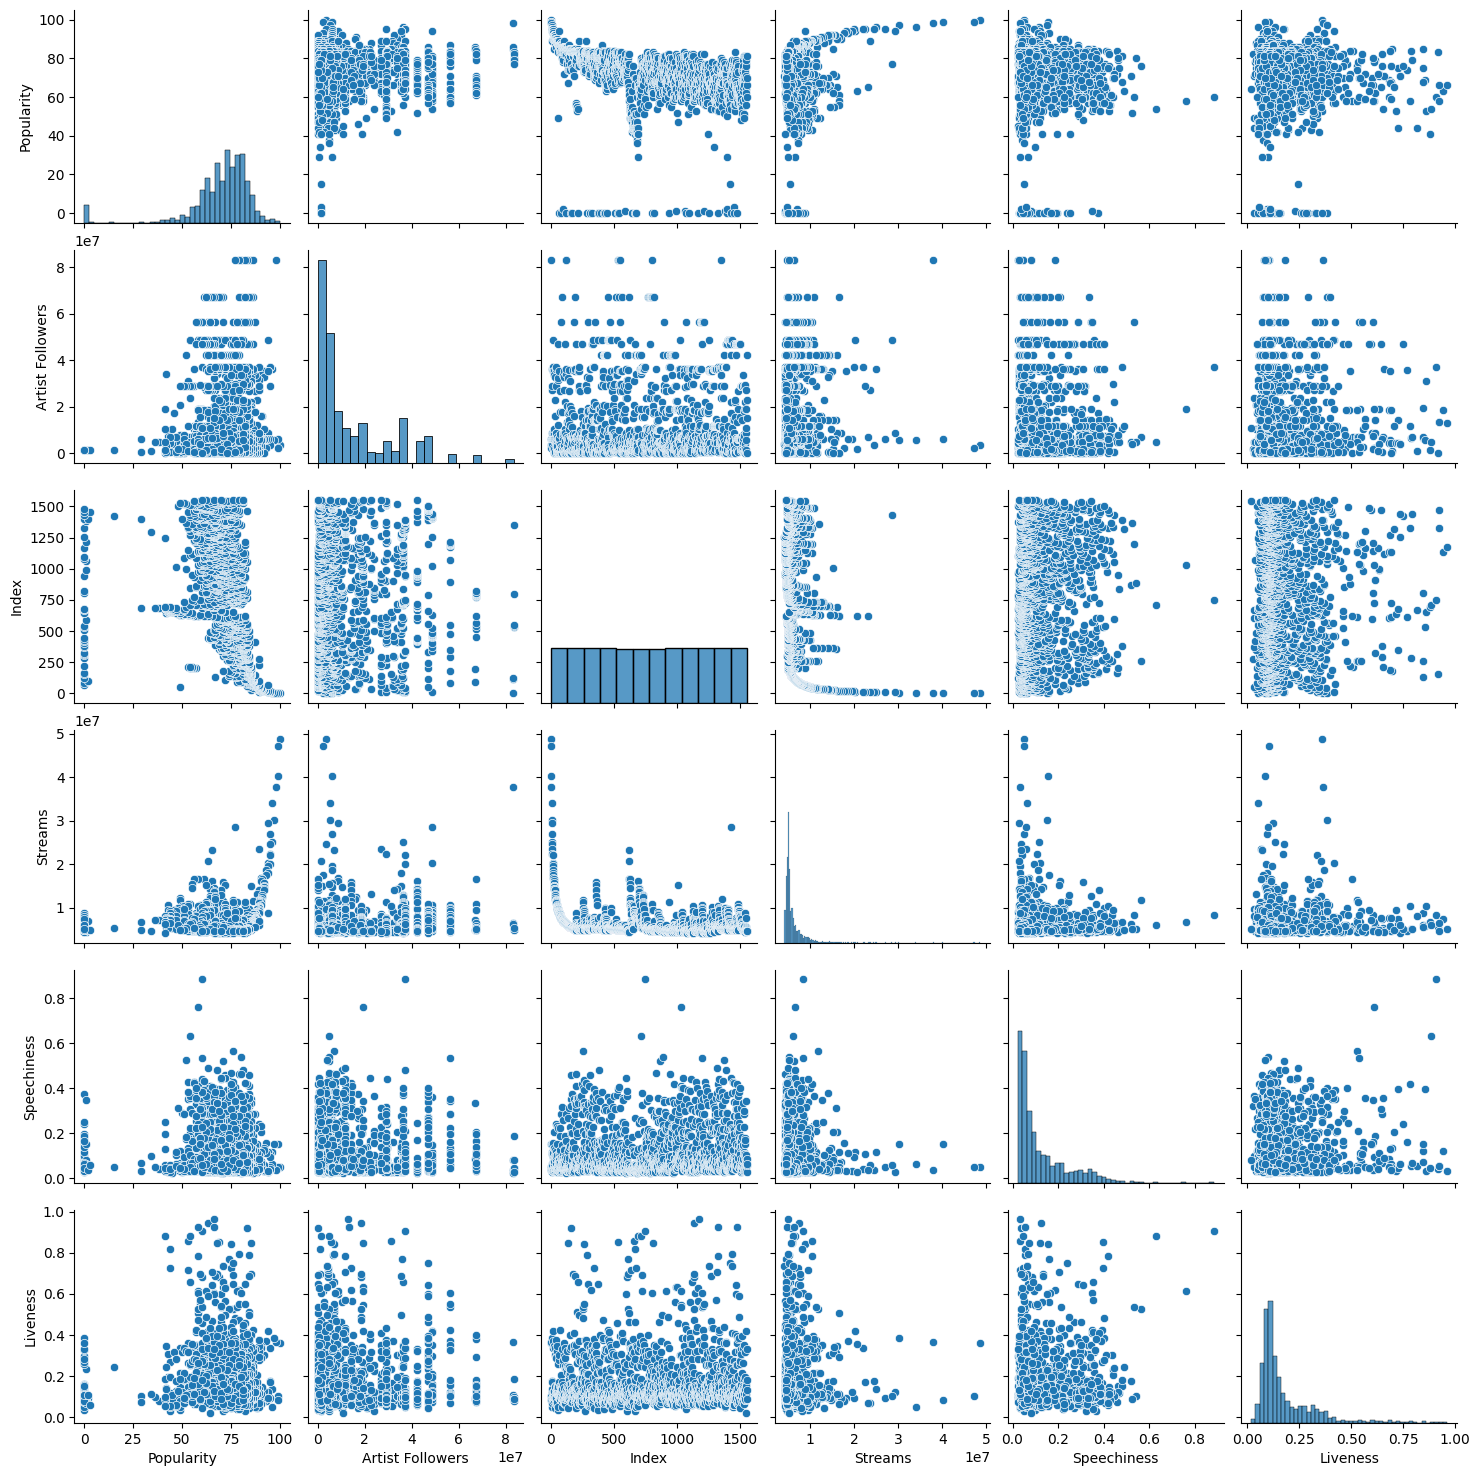

In [ ]:
sns.pairplot(top_five)

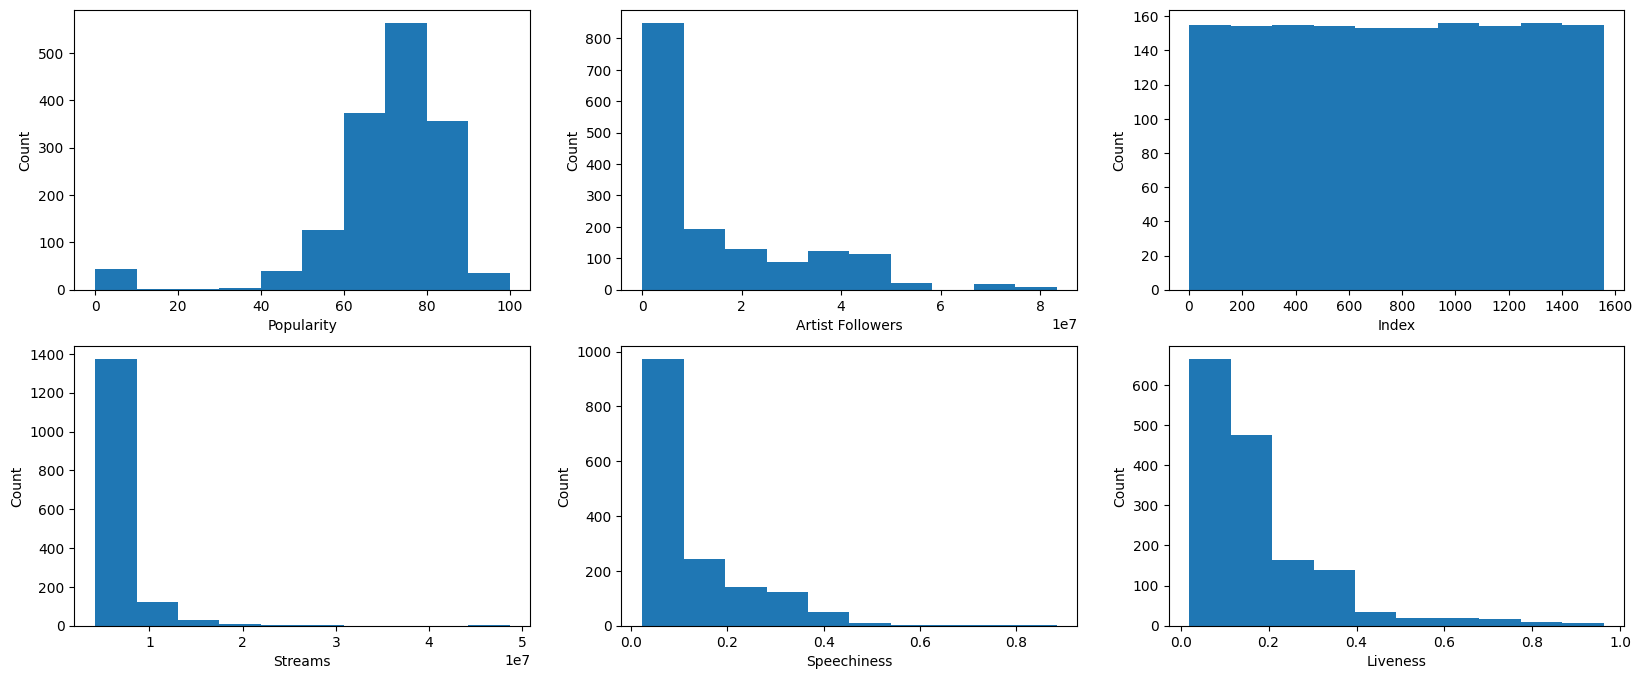

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(20, 8))
column_names = top_five.columns
n = 0
for ax in axs.flatten():
    if n < len(column_names):
        ax.hist(top_five[column_names[n]])
        ax.set_xlabel(column_names[n])
        ax.set_ylabel('Count')
        n = n + 1
    else:
        ax.set_axis_off()

#Data Processing


In [ ]:
top_five.describe()

,Popularity,Artist Followers,Index,Streams,Speechiness,Liveness
count,1545.000000,1.545000e+03,1545.000000,1.545000e+03,1545.000000,1545.000000
mean,70.089320,1.471690e+07,779.135922,6.337136e+06,0.123656,0.181202
std,15.824034,1.667579e+07,449.593861,3.375402e+06,0.110383,0.144071
min,0.000000,4.883000e+03,1.000000,4.176083e+06,0.023200,0.019700
25%,65.000000,2.123734e+06,389.000000,4.915080e+06,0.045600,0.096600
50%,73.000000,6.852509e+06,780.000000,5.269163e+06,0.076500,0.124000
75%,80.000000,2.269875e+07,1169.000000,6.452492e+06,0.165000,0.217000
max,100.000000,8.333778e+07,1556.000000,4.863345e+07,0.884000,0.962000


In [ ]:
count_nulls(top_five)

(1545, 6)
Series([], dtype: int64)


After looking over the data and ensuring no nulls appeared, I'm comfortable with going forward with the data.

##Top Five

In [ ]:
X = top_five.drop('Popularity', axis = 1)
y = top_five['Popularity']

###Modeling and Testing

I am going to start with a Decision Tree, then I will see if I can improve predictions with XGBoost.

Decision Tree

In [ ]:
numLoops = 500

rms_error = np.zeros(numLoops)

for idx in range(0,numLoops):
  X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)
  model = DecisionTreeRegressor()
  model.fit(X_train,y_train)
  y_pred = model.predict(X_test)
  rms_error[idx] = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"CV RMSE: {rms_error.mean().round(2)}")

CV RMSE: 10.31


In [ ]:
max_depths = [1,2,3,4,5,6,7,8,9,10]
rms_depth = np.zeros(len(max_depths))
std_depth = np.zeros(len(max_depths))

numLoops = 500

for n, depth in enumerate(max_depths): 
  rms_error = np.zeros(numLoops)

  for idx in range(0,numLoops):
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)
    model = DecisionTreeRegressor(max_depth=depth) 
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    rms_error[idx] = np.sqrt(mean_squared_error(y_test, y_pred))

  rms_depth[n] = rms_error.mean()
  std_depth[n] = rms_error.std()


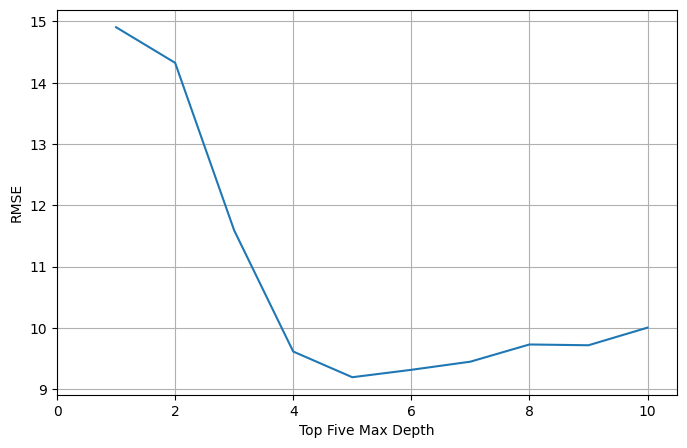

In [ ]:
plt.figure(figsize = (8,5))
plt.plot(max_depths, rms_depth)
plt.xlabel('Top Five Max Depth')
plt.ylabel('RMSE')
plt.xlim(0, 10.5)
plt.grid()

In [ ]:
numLoops = 500

rms_error = np.zeros(numLoops)

for idx in range(0,numLoops):
  X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)
  model = DecisionTreeRegressor(max_depth=5)
  model.fit(X_train,y_train)
  y_pred = model.predict(X_test)
  rms_error[idx] = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"CV RMSE: {rms_error.mean().round(2)}")

CV RMSE: 9.31


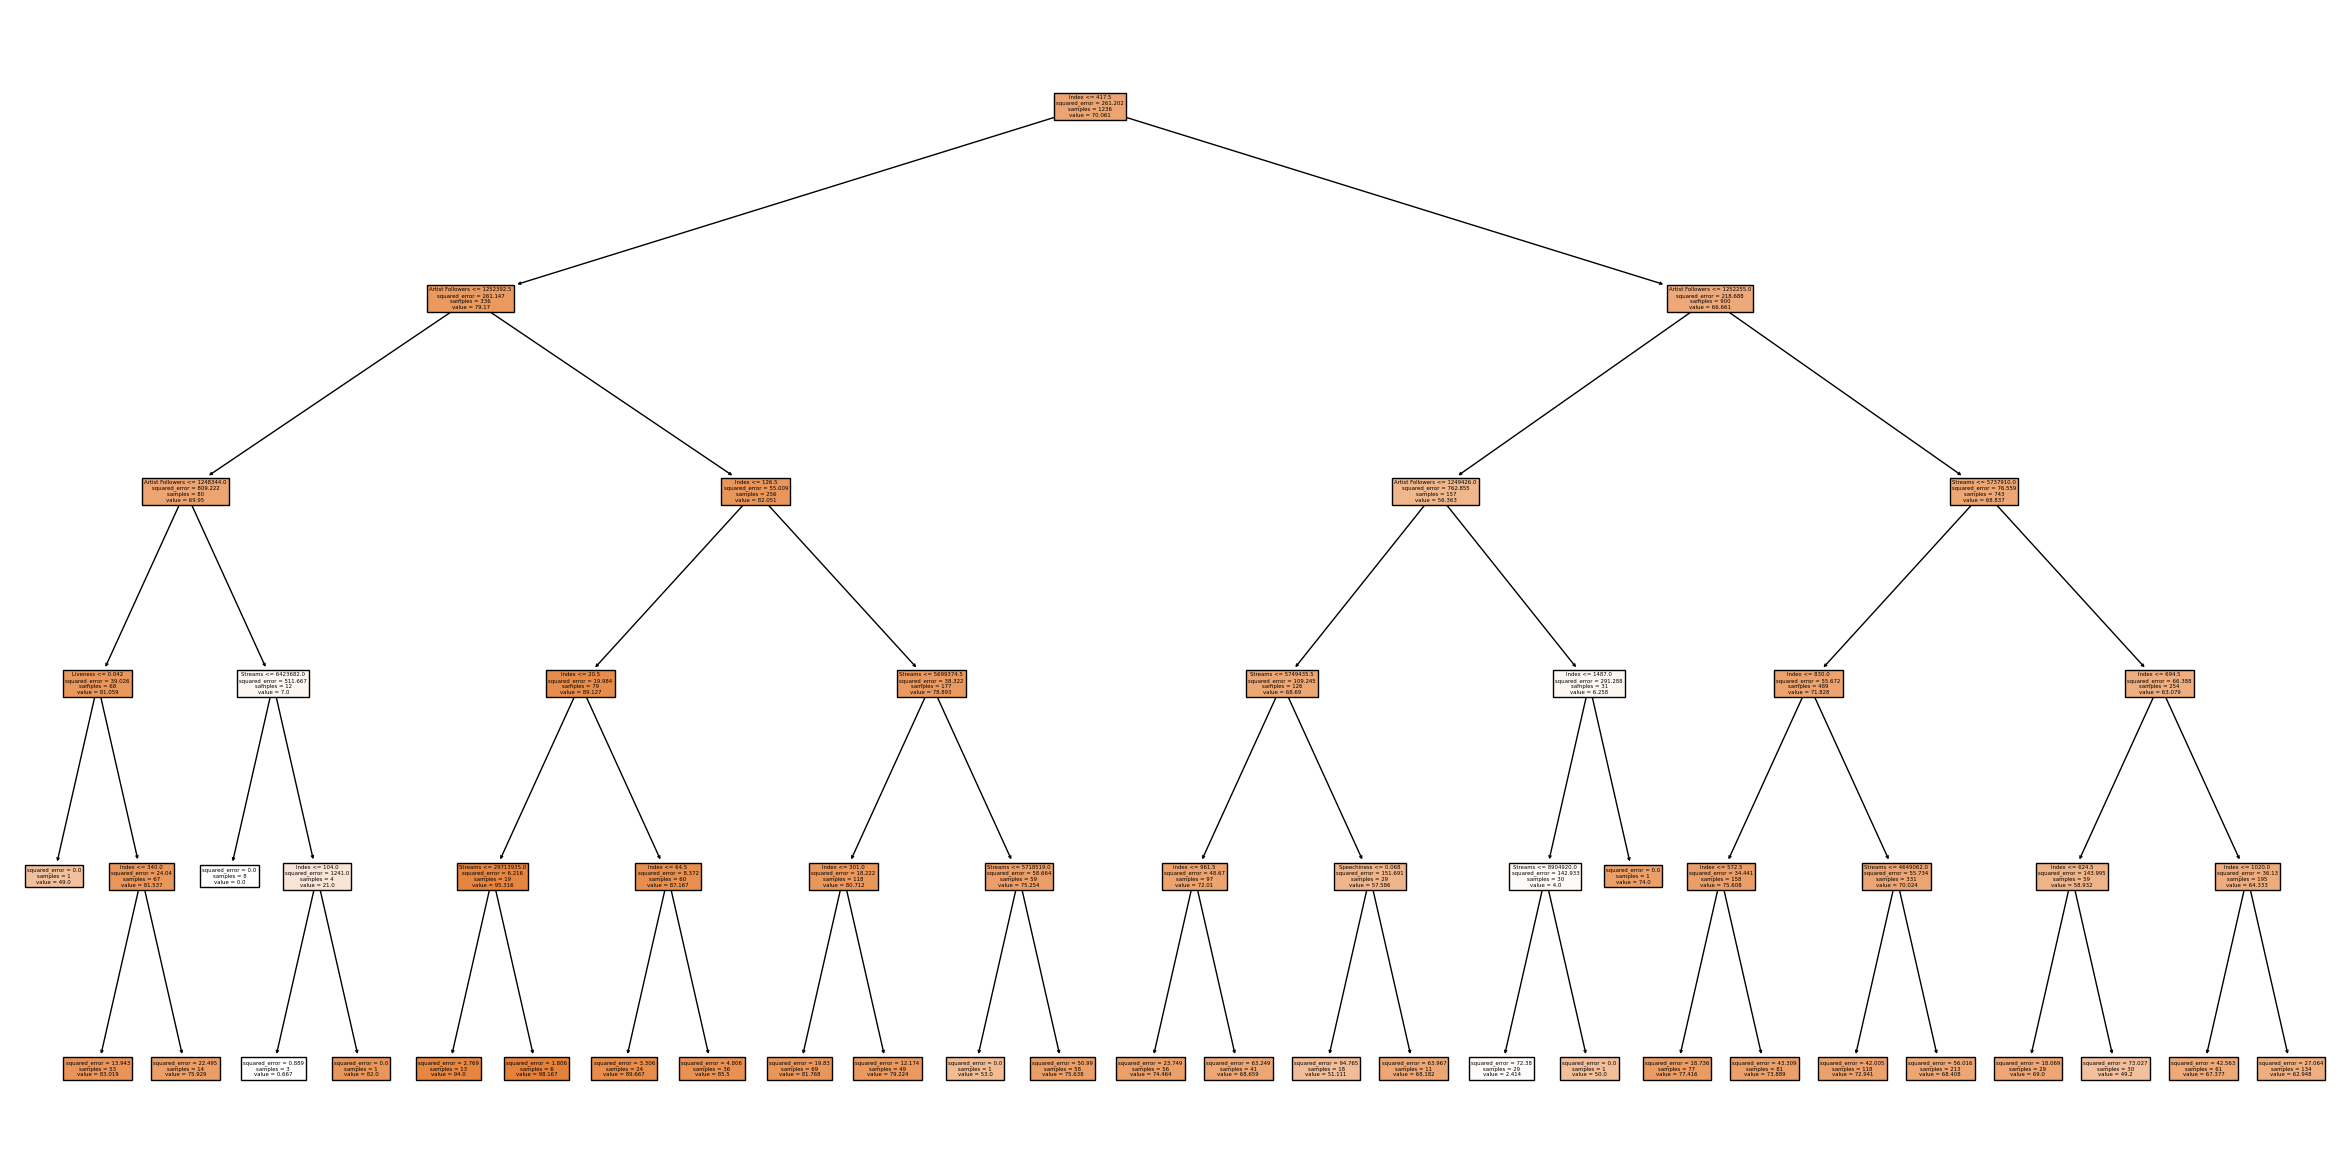

In [ ]:
plt.figure(figsize=(30,15))
tree_plot = tree.plot_tree(model, feature_names=X.columns, filled=True)

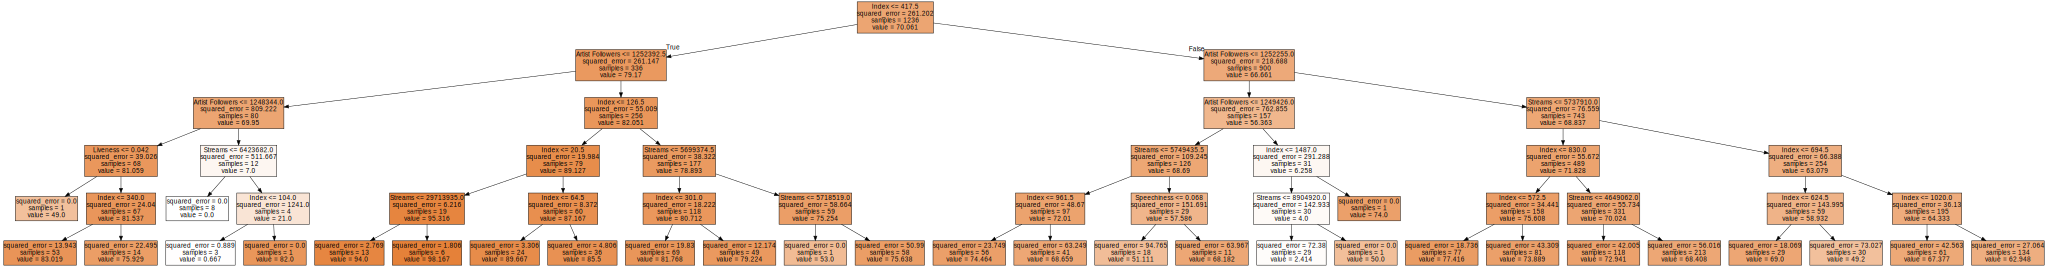

In [ ]:
display(graphviz.Source(tree.export_graphviz(model, feature_names=X.columns, filled = True)))

XGBoost

In [ ]:
numLoops = 500
mse_xgb  = np.zeros(numLoops)

for idx in range(0,numLoops):
  X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.15)
  xgbr = xgb.XGBRegressor(objective ='reg:squarederror', verbosity=0, seed = 10)
  xgbr.fit(X_train,y_train)
  y_pred_xgb = xgbr.predict(X_test)
  mse_xgb[idx] = mean_squared_error(y_test,y_pred_xgb)


print(f'RMSE: {np.sqrt(mse_xgb).mean()}')

RMSE: 7.901833082359016


In [ ]:
# Specify the parameters you want to try and their ranges. 
param_test = {
 'max_depth':[3,4,5,6,7],
 'learning_rate' : [0.1, 0.2, 0.3, 0.4], 
 'n_estimators': [20,40,60,80,100,120,140],
}

# Perform the grid search
gsearch = GridSearchCV(estimator = xgb.XGBRegressor(objective = 'reg:squarederror'), 
                       param_grid = param_test,
                       scoring='neg_mean_squared_error',
                       cv=5
)

# Fit to training data 
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.05)
model = gsearch.fit(X_train,y_train)

# See grid search results
print(model.best_params_)

{'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 60}


In [ ]:
numLoops = 500
mse_xgb  = np.zeros(numLoops)

for idx in range(0,numLoops):
  X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.15)
  xgbr = xgb.XGBRegressor(objective ='reg:squarederror', verbosity=0, learning_rate = 0.2, max_depth = 3, n_estimators = 60)
  xgbr.fit(X_train,y_train)
  y_pred_xgb = xgbr.predict(X_test)
  mse_xgb[idx] = mean_squared_error(y_test,y_pred_xgb)

print(f'RMSE: {np.sqrt(mse_xgb).mean()}')

RMSE: 7.645317119469333


Text(0, 0.5, 'Feature Importance Score')

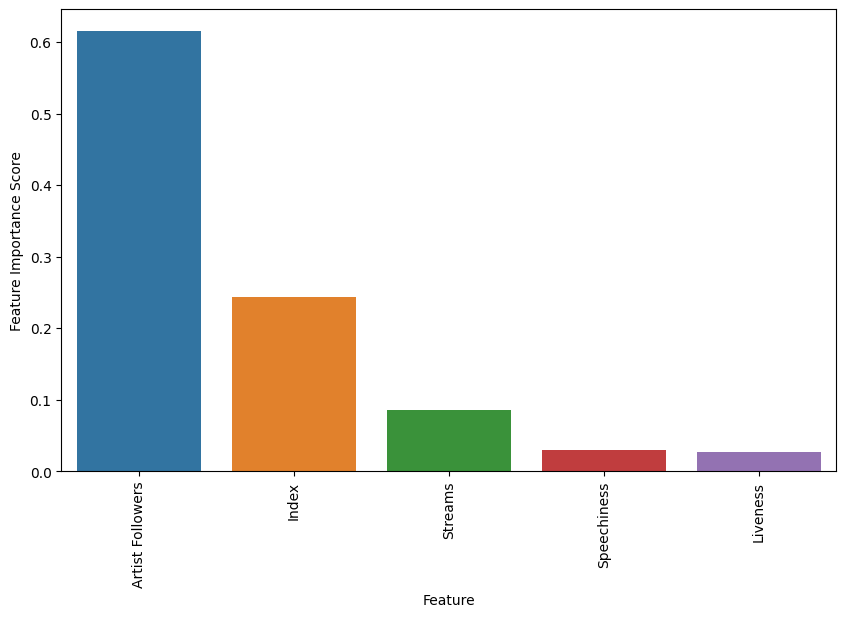

In [ ]:
feat_imp = pd.Series(xgbr.feature_importances_, index=X.columns)
plt.figure(figsize = (10,6))
ax = sns.barplot(x = feat_imp.index, y = feat_imp.values)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
plt.xlabel('Feature')
plt.ylabel('Feature Importance Score')

###Top Five Conclusion
The top five features were modeled and tested with a Decision Tree where it achieved an RMSE below 9.4 consistently at a depth of 5, then ran through XGBoost where it achieved an RMSE below 7.65 consistently.


##Top Three
After seeing the Feature graph I decided I wanted to run another Decision Tree and XGBoost with the top three features.


In [ ]:
top_three = top_five[['Popularity','Artist Followers', 'Index', 'Streams']]

In [ ]:
X = top_three.drop('Popularity', axis = 1)
y = top_three['Popularity']

###Modeling and Testing

Decision Tree

In [ ]:
numLoops = 500

rms_error = np.zeros(numLoops)

for idx in range(0,numLoops):
  X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)
  model = DecisionTreeRegressor()
  model.fit(X_train,y_train)
  y_pred = model.predict(X_test)
  rms_error[idx] = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"CV RMSE: {rms_error.mean().round(2)}")

CV RMSE: 9.87


In [ ]:
max_depths = [1,2,3,4,5,6,7,8,9,10]
rms_depth = np.zeros(len(max_depths))
std_depth = np.zeros(len(max_depths))

numLoops = 500

for n, depth in enumerate(max_depths): 
  rms_error = np.zeros(numLoops)

  for idx in range(0,numLoops):
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)
    model = DecisionTreeRegressor(max_depth=depth) 
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    rms_error[idx] = np.sqrt(mean_squared_error(y_test, y_pred))

  rms_depth[n] = rms_error.mean()
  std_depth[n] = rms_error.std()

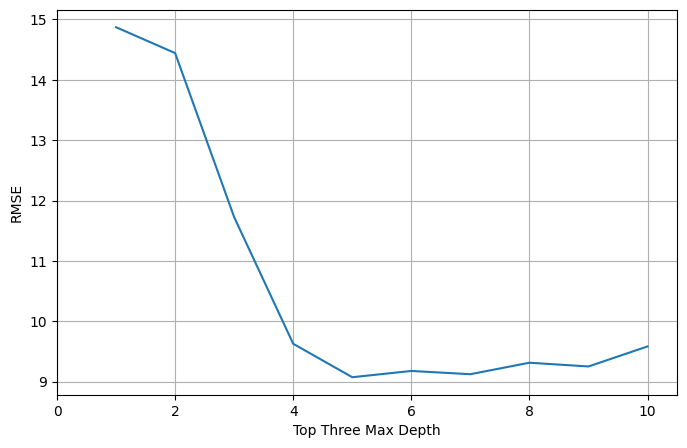

In [ ]:
plt.figure(figsize = (8,5))
plt.plot(max_depths, rms_depth)
plt.xlabel('Top Three Max Depth')
plt.ylabel('RMSE')
plt.xlim(0, 10.5)
plt.grid()

In [ ]:
numLoops = 500

rms_error = np.zeros(numLoops)

for idx in range(0,numLoops):
  X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)
  model = DecisionTreeRegressor(max_depth=5)
  model.fit(X_train,y_train)
  y_pred = model.predict(X_test)
  rms_error[idx] = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"CV RMSE: {rms_error.mean().round(2)}")

CV RMSE: 9.0


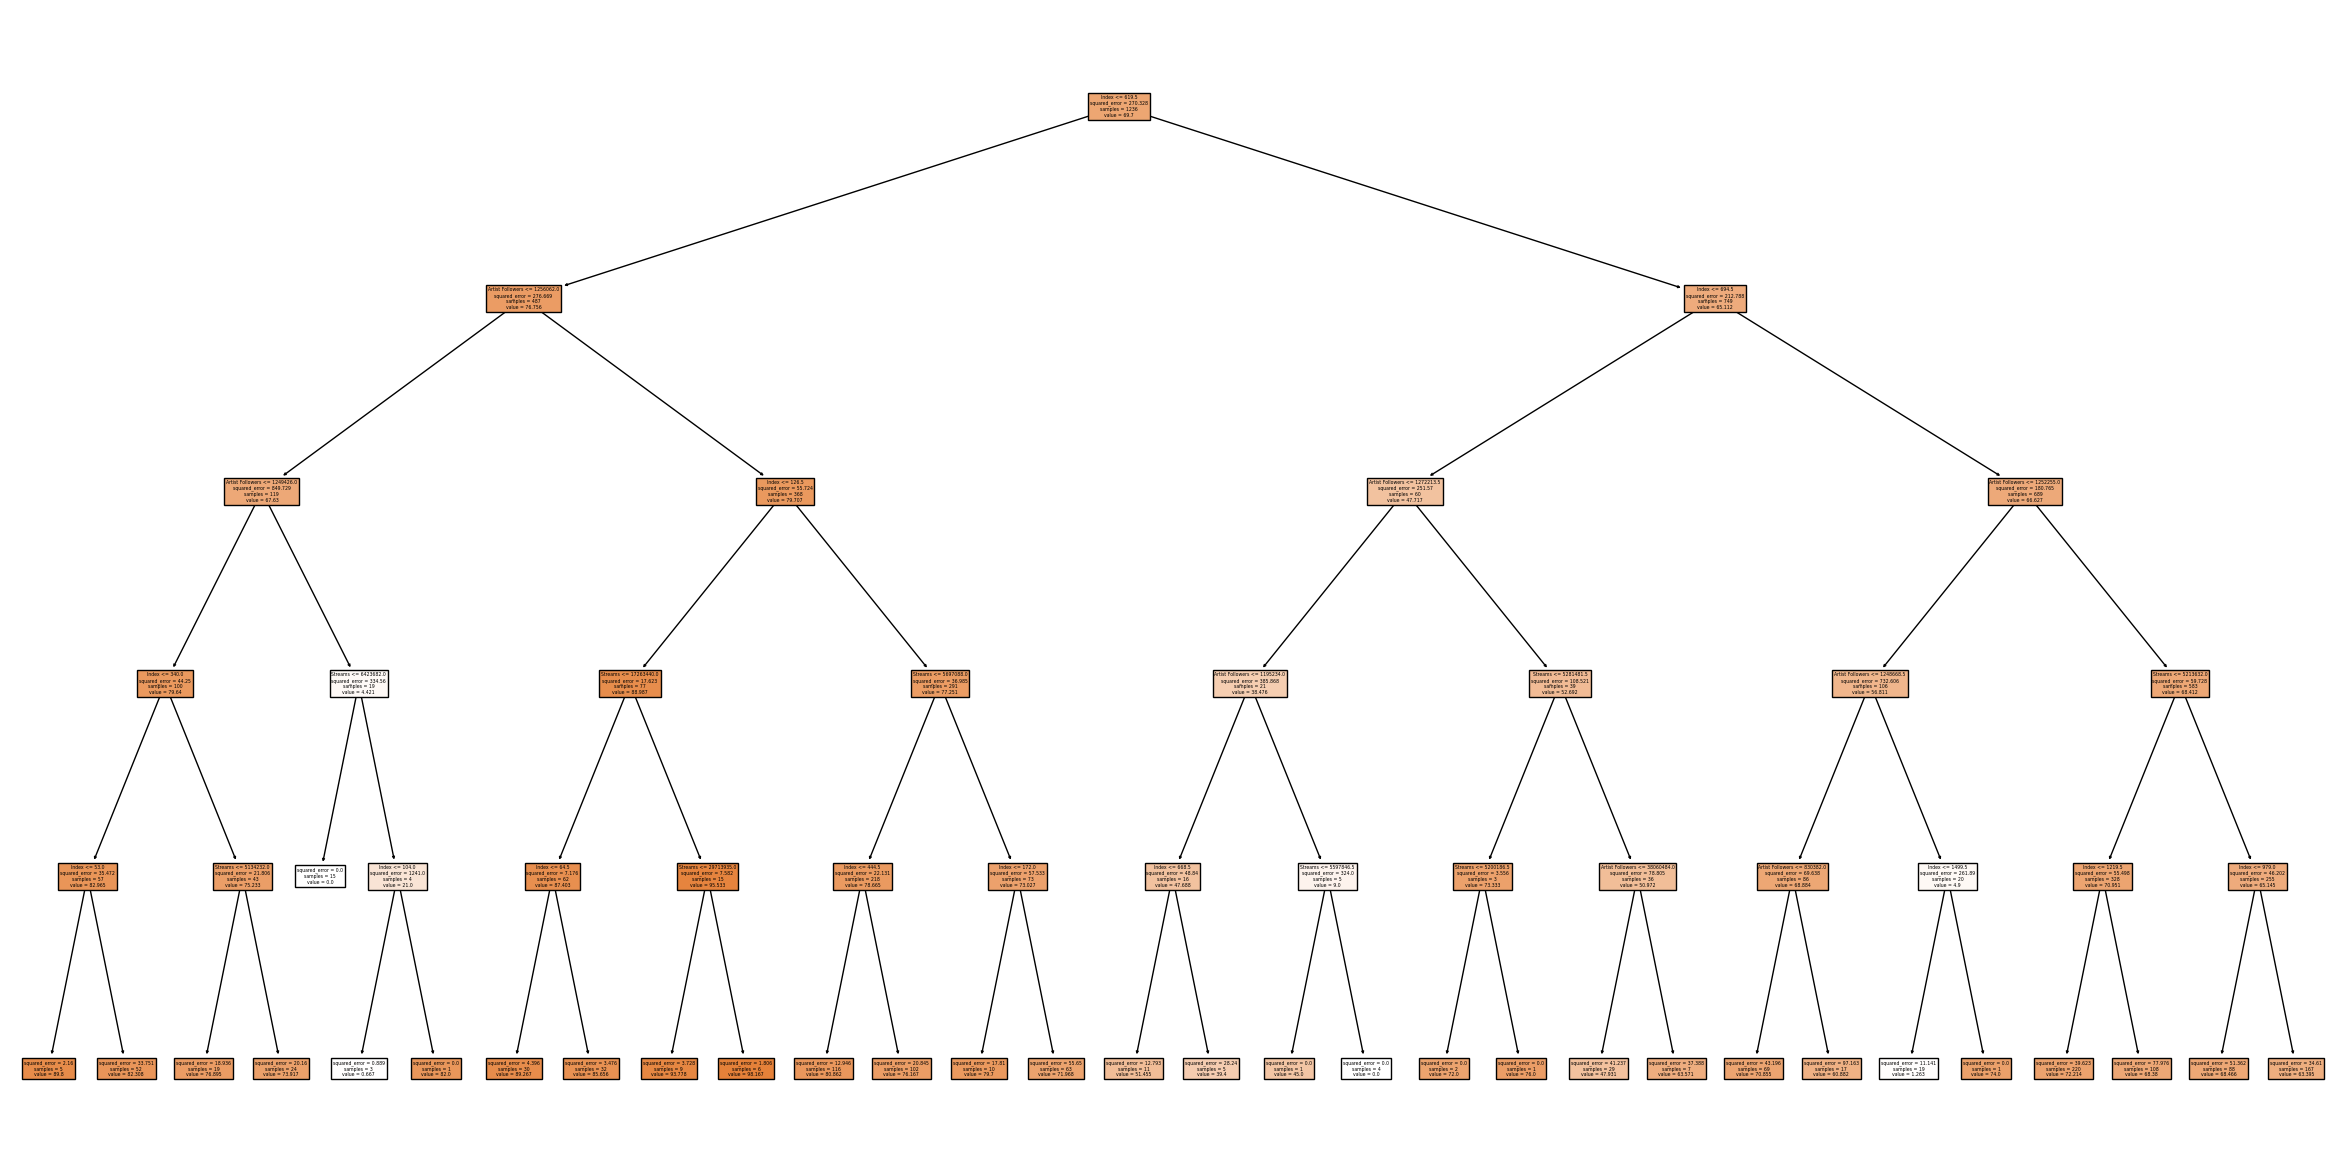

In [ ]:
plt.figure(figsize=(30,15))
tree_plot = tree.plot_tree(model, feature_names=X.columns, filled=True)

XGBoost

In [ ]:
numLoops = 500
mse_xgb  = np.zeros(numLoops)

for idx in range(0,numLoops):
  X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.15)
  xgbr = xgb.XGBRegressor(objective ='reg:squarederror', verbosity=0, seed = 10)
  xgbr.fit(X_train,y_train)
  y_pred_xgb = xgbr.predict(X_test)
  mse_xgb[idx] = mean_squared_error(y_test,y_pred_xgb)


print(f'RMSE: {np.sqrt(mse_xgb).mean()}')

RMSE: 7.837882166531397


In [ ]:
# Specify the parameters you want to try and their ranges. 
param_test = {
 'max_depth':[3,4,5,6,7],
 'learning_rate' : [0.1, 0.2, 0.3, 0.4], 
 'n_estimators': [20,40,60,80,100,120,140],
}

# Perform the grid search
gsearch = GridSearchCV(estimator = xgb.XGBRegressor(objective = 'reg:squarederror'), 
                       param_grid = param_test,
                       scoring='neg_mean_squared_error',
                       cv=5
)

# Fit to training data 
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.05)
model = gsearch.fit(X_train,y_train)

# See grid search results
print(model.best_params_)

{'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 80}


In [ ]:
numLoops = 500
mse_xgb  = np.zeros(numLoops)

for idx in range(0,numLoops):
  X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.15)
  xgbr = xgb.XGBRegressor(objective ='reg:squarederror', verbosity=0, learning_rate = 0.2, max_depth = 4, n_estimators = 80)
  xgbr.fit(X_train,y_train)
  y_pred_xgb = xgbr.predict(X_test)
  mse_xgb[idx] = mean_squared_error(y_test,y_pred_xgb)

print(f'RMSE: {np.sqrt(mse_xgb).mean()}')

RMSE: 7.562702239646812


###Top Three Conclusion
The top five features were modeled and tested with a Decision Tree where it achieved an RMSE below 9.28 consistently at a depth of 5, then ran through XGBoost where it achieved an RMSE below 7.57 consistently.


#Conclusion
After working through the data I was able to use a Random Forest to find my top five features for testing, visualize them through correlation matrix and graphs, then do final testing and modeling through Decision Tree with an RMSE below 9.4 and XGBoost with a final RMSE below 7.65. After that, I modeled and tested the top three features that had an RMSE below 9.28 with the Decision Tree and an RMSE below 7.57 with XGBoost Going forward I will accomplish this with other more expansive features with the overall goal of narrowing the RMSE and making a better predictive model.
